# Introduction 

The following notebook provides a comprehensive overview and implementation of the [Private Aggregation of Teacher Ensembles (PATE)](https://arxiv.org/pdf/1610.05755.pdf) using [PyTorch](https://pytorch.org/) and [PySyft](https://github.com/OpenMined/PySyft). The dataset that is used is [Home Credit Default Dataset](https://www.kaggle.com/c/home-credit-default-risk/overview) which contains features about credit applicants drawn from the internal operations of a financial insititution as well as corresponding Credit Bureau data. The target is whether or not the appliant will default on their debt. The following sections contain a detailed a theoretical overview and subsequent implementation.

# Background

## Private AI

### Introduction to Private AI
A major concern of production machine learning systems is maintaining the privacy of the data that was used to train it. This is especially relevant in use cases with private and sensitive information. In the Private AI literature, a party looking to reveal information about the data that a model is trained on is called an adversary. Even if the adversary does not have access to the data explicitly, access to the model and/or its outputs can reveal information about the data that the model was trained on.

### Privacy Attacks
An adversary employs a privacy attack in order to reveal information about the data that the model was trained on. Two attacks that are well researched in the Private AI Literature: 
- **Model Inversion Attack:** Try to obtain information about typical samples in the training dataset. This involves attacks that euther reconst a specific sample or representative samples in the training dataset. 

- **Membership Inference Attack:** Try to ascertain whether or not a sample was used to train a model. 

### Threat Models
Each adversary has a threat model that informs the manner in which they go about a privacy attack. The threat model describes the level of access that an adverary has to a model. At a high level, there are two threat models: 
- **Black Box Adversary:** Solely able to query the model. Thus, the only information made available to the adversary is the inputs and outputs of the model. 
- **White Box Adversary:** The adversary is able to query the model as well as have access to its internal parameters. This implies that the adversary has access to the input, output and the intermediate computations made by the model. 

## Differential Privacy 

### Introduction to Differential Privacy
In order to evaluate the robustness of a model to privacy attacks, we have to define a framework through which we can obtain a quantitative measure that describes its performance in terms of privacy. To this end, Differential Privacy has been proposed and offers a powerful mechanism to assess and rank the privacy of models. It does so based on the sensitivity of a model to the inclusion of a specific sample.

<p align="center">
<img width="433" alt="Screen Shot 2021-09-28 at 5 41 20 PM" src="https://user-images.githubusercontent.com/34798787/137939981-a9968386-4a28-4447-ad9e-5babab497eeb.png">  
</p>
<center>
<a href=https://www.nist.gov/blogs/cybersecurity-insights/differential-privacy-privacy-preserving-data-analysis-introduction-our>Source</a>  
</center>



Specified formally, the definition of differential privacy is given by the below inequality: 
<p align="center">
<img width="185" alt="Screen Shot 2021-10-19 at 11 40 16 AM" src="https://user-images.githubusercontent.com/34798787/137944948-cffd9db8-5a29-4f98-bf5a-b5b7d4bbe25b.png">
</p>

where M is the model, x is orginal the dataset, x' is the original dataset augmented to include or exclude a single sample. $\epsilon$ acts as a metric of privacy loss based on a differential change in data. The smaller the value is, the better privacy protection. Rearranging the inequality yields:

<p align="center">
<img width="345" alt="Screen Shot 2021-10-19 at 3 37 50 PM" src="https://user-images.githubusercontent.com/34798787/137978800-d3c56d46-5b7c-4b37-a61e-6f7b8daa61d2.png">
</p>
This is a strong to guarentee to achieve in practice so a failure probability in order to relax this constraint we add a failure probability, $\delta$, to the RHS of the inequality: 

<p align="center">
<img width="400" alt="Screen Shot 2021-10-19 at 3 35 50 PM" src="https://user-images.githubusercontent.com/34798787/137978567-7a0313bc-d9cd-4a0d-9f9b-7df3711f2c3d.png">
</p>

As long as delta is smaller than the probability that a sample occurs in the dataset, we will still obtain a high degree of privacy. This allows us to relax the guarentee we need to provide while maintaining an acceptable level of privacy. As parameters that define the interval of differential privacy, a model with $\epsilon$ and $\delta$ is ($\epsilon$, $\delta$)-differentially private. 



### Composition in Differential Privacy
An important consideration in practice is determining the differential privacy of a composition of a number of models. Drawing from [The Algorithmic Foundations
of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf), the composition of k differentially private mechanisms, where the $i$th mechanism is ($\epsilon_{i}$, $\delta_{i}$)-differentially private, for 1 $\leq$ i $\leq$ k, is ($\sum \epsilon_{i}$, $\sum \delta_{i}$)-differentially private.



### Privacy Amplication Theorem
If we select a subset of samples from the dataset, it is intuitive that we would incur a privacy loss that is lower than that of using the entire dataset. This is the essence of the Privacy Amplication Theorem which states that if we randomly sample a q of the data, rather than the entrie dataset, then an ($\epsilon$, $\delta$) private mechansm becomes ($q\epsilon$, $q\delta$)-differentially private.



### Fundamental Law of Information Recovery
The Fundamental Law of Information Recovery states that overly accurate estimates of too many statistics erodes the privacy of data. This implies that continuously querying a private mechanism will increase the privacy loss incurred. 

### Implications for Training and Testing Machine Learning Models
Within the context of training and testing a machine learning model, we can use Composition in Differentially Privacy and Privacy Amplication Theorem to derive the privacy loss in situations where we are iteritvely querying a model with a random subset of the data, such as in the case of training and testing Neural Networks. The summation of privacy losses over queries follows the intuition from the Fundamental Law of Information Recovery that continuously querying a private mechanism will increase the privacy loss incurred. 

## Differentially Private Stochastic Gradient Descent (DP-SGD)

### Introduction to DP-SGD
The seminal paper that applies Differential Privacy to Deep Learning is [Deep Learing with Differential Privacy](https://arxiv.org/abs/1607.00133). In this paper, a differentially-private variant of stochastic gradient descent is proposed (DP-SGD). 

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/138136971-c51261d3-73de-4afb-97b9-71e149ddfacd.png">
</p>

<center>
<a href=https://secml.github.io/class4>Source</a>  
</center>




### Estimating Differential Privacy for a Single Gradient Update
As in vanilla SGD, we start with calculating the gradient of a batch of data. In order to limit the amount information we learn from the batch, we clip the gradient at C which is a hyperpareter for the algorithim. We than add noise $\sigma^2$ proportional C and than update the parameters of the model. 
 


### Estimating Differential Privacy for accross Gradient Updates
In order to get the total privacy loss, we must aggregate the privacy loss for each gradient update. Based on Composition in Differential Privacy and The Privacy Amplicaiton Theorem, we can define a Naive estimate of the upper bound of the privacy loss. Given an ($\epsilon$, $\delta$)-differentially private algorithim, with a batch size proportional to $q$ run for T iterations has a differential privacy of ($Tq\epsilon$, $Tq\delta$). 

It turns out that a more complex analysis can yield lower bounds for the privacy loss. Thus, finding the lowest bound possible allows us to more accurately determine the privacy loss and to avoid overstimating it. For example, the Strong Compositon Theorem can be used to prove an even lower bound on the privacy loss. In the DP-SGD paper, the authors propose the Moments Accountant which provided the lowest bound 
- **Naive Analysis:** ($Tq\epsilon$, $Tq\delta$)-differentially private
- **Strong Composition Theorem:** ($O(q\epsilon\sqrt{Tlog(1/\delta)})$, $Tq\delta$)-differentially private
- **Moments Accountant:** ($O(q\epsilon\sqrt{T})$, $\delta$)-differentially private.



### Moments Accountant
The fundamental insight of the Moments Accountant technique is that the privacy loss is a random variable. Thus, if we look at the distribution of the privacy loss, we can see that $\epsilon$ defines the privacy budget for the loss and $\delta$ provides an upper bound on the tail of the distribution. 

<p align="center">
<img width="500" alt="Screen Shot 2021-10-20 at 1 50 02 PM" src="https://user-images.githubusercontent.com/34798787/138145128-0d67885f-a5c4-448f-9fcd-78fa0452a3ce.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=jm1Sfdno_5A>Source</a>  
</center>

By treating the privacy loss as a random variable, we can leverage probability theory to derive a lower bound on the privacy loss. Specifically, the Moments Accountant Technique uses the moments of the distribution (ie mean, variance, skewness and kurtosis) in order to do so. Incorporating the higher order information of the distibution made available through the moments  allows us to derive a lower bound on the privacy loss: $O(q\epsilon\sqrt{T})$, $\delta$). For a deeper look into the Moments Accountant technique, refer to [Deep Learing with Differential Privacy](https://arxiv.org/abs/1607.00133).






## Private Aggregation of Teacher Ensembles (PATE)


### Introduction to PATE
In [Scalable Private Learning with PATE](https://arxiv.org/abs/1802.08908), authors set out solve the problem of preserving the privacy of training data when training classfiers. They began with defining certain criteria for the solution:
- Differential privacy protection guarentees
- Intuitive privacy protection guarentees 
- **Independent of learning algorithim**

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139095511-ff27899c-80f0-45bf-a4d0-d18820c20e34.png">
</p>

<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>











### Ensembling

In differential privacy, we seek to learn general trends from the data. That is, the outcome of the the prediction of a sample, should be the same whether or not we choose to include an sample in the dataset for each sample in the dataset. One natural way to achieve this to use an ensemble of models trained on random subsets of the dataset. In this way, the prediction for a specific sample is less likely to depend on a single example. Furthermore, if there is a strong consensus among the ensemble, it is likely the prediction stems from a general trend rather than a specific sample. In practice, this allows us to define a lower, data dependent bound on the privacy loss. 

Although ensembling enhances differentially privacy, it is still possible that the inclusion/exclusion of samples in the various teachers will change the outcome of the predictions. This is especially the case when there is not a strong consensus among the ensemble; the vote of single teacher can sway the prediction of the output. 




### Noisy Aggregation

In order to address the aforementioned shortcoming, we can aggregate the votes of the teachers in a noisy way. This is realized by adding noise to the final prediction.

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139089966-fa783578-cc52-4a58-bcb4-9a06432868ac.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>




### Student Training
Although the aggregated teacher is a good step towards differential privacy, it does have some shortcomings: 
- Each prediction increases total privacy loss. Thus, the privacy budget creates a tradeoff between the accuracy and number of predictions.
- Inspection of internal may reveal private data. However, we want privacy guarentees that hold for white box adversaries. 

As a result, the PATE framework introduces a student network that is trained on publicly available data using labels from Teacher Model.

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/138165916-a61f044d-4d45-4f5f-8e62-3fca94b65b84.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>


# Demo

## Overview

The following demo consists of three sections:
- **Data Preparation** 
    - Define Dataset
    - Define Dataloader
- **Model Preparation** 
    - Model Defintion
- **Training and Validation**
    - Training Teacher Ensemble
    - Generating Labelled Public Dataset
    - Train and Evaluate Student Model
- **Interpret Results** 
    - Accuarcy 
    - Privacy Loss
    


## Environment Configuration


In [286]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

from syft.frameworks.torch.dp import pate


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split

In [317]:
# DATA_PATH = "train.csv"
DATA_PATH = "/ssd003/projects/pets/datasets/home_credit/train.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_PERC = .75
BATCH_SIZE = 1024
NUM_TEACHERS = 7
TEACHER_EPOCHS = 50
STUDENT_EPOCHS = 50

## Data Preparation

### Define Dataset

In [341]:
class HomeCredit(Dataset): 
    """Dataset for Vertical Federated Learning"""

    def __init__(self, data, labels):
        """
        Args:
            data (Numpy Array) : Numpy Array with Features
            labels (Numpy Array) : Numpy Array with Labels. None if not available. 
        """
        self.data = data
        self.labels = labels
    
    def __getitem__(self, idx):
        """Return record single record"""
        features = self.data[idx].astype(np.float32)
        label = self.labels[idx]

        return features, label
    
    def __len__(self):
        """Return Length"""
        return len(self.data)

### Define Dataloaders

In [342]:
def get_loaders(data, num_teachers, batch_size):
    """ 
    Function to create data loaders for the Teacher Class.
    
    :param data: Numpy Array of the data 
    :param num_teacher: Number of teacher models 
    :param batch_size: Batch size for the dataloaders

    :return: Return teacher loaders and student loader (with actual labels)
    """ 
    loaders = []
    sample_size = len(data) // (num_teachers + 1)

    for i in range(num_teachers):
        indices = list(range(i*sample_size, (i+1)*sample_size))
        subset_data = Subset(data, indices)
        loader = DataLoader(subset_data, batch_size=batch_size)
        loaders.append(loader)
    
    return loaders[1:], loaders[0]

In [343]:
def student_loader(student_train_loader, labels):
    """ 
    Function to modify the student loader to include labels from teacher
    
    :param student_train_loader: The student loader with actual labels 
    :param labels: Labels from the teacher model

    :return: Return iterator  
    """ 
    # Use teacher to label data (discard actual labels)
    for i, (data, _) in enumerate(iter(student_train_loader)):
        yield data, torch.from_numpy(labels[i*len(data): (i+1)*len(data)])

In [344]:
# Load Data and Labels
data = pd.read_csv(DATA_PATH)
labels = data.pop("target")
data = data.to_numpy(dtype=np.float32)
labels = labels.to_numpy(dtype=np.int)
dataset = HomeCredit(data=data, labels=labels)

# #OverSample
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X_train_oversampled, y_oversampled = oversample.fit_resample(dataset.data, dataset.labels)

# # Get train and validation size
# train_size = int(len(X_train_oversampled) * TRAIN_PERC)
# val_size = len(X_train_oversampled) - train_size
# train_data, val_data = random_split(X_train_oversampled, [train_size, val_size])

# Get train and validation size
train_size = int(len(dataset) * TRAIN_PERC)
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])




# Define dataloaders
t_loaders, s_loader = get_loaders(train_data, NUM_TEACHERS, BATCH_SIZE) # Teacher loaders, student loader
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, drop_last=True) # Loader to validate in Train Ensemble and Train Student Model



## Model

In [345]:
class HCModel(torch.nn.Module):
    """ 
    Model for Credit Bureau
    
    Attributes
    ----------
    feat_dim: 
        Dimensionality of Data
    Methods
    -------
    forward(x):
        Performs a forward pass through the Credit Bureau Model
    """
    def __init__(self, feat_dim): 
        super(HCModel, self).__init__()
        self.feat_dim = feat_dim
        self.layers = nn.Sequential(
            nn.Linear(self.feat_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, feat):
        pred = self.layers(feat)
        return pred

In [346]:
# Initialize models and otptimizers for teacher ensembles
models = [HCModel(feat_dim=data.shape[1]) for i in range(NUM_TEACHERS)]
opts = [torch.optim.Adam(model.parameters(), lr=.001,  betas=(0.9, 0.999)) for model in models]

## Training and Validation

### Train Teacher Ensemble

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139118910-63e067a7-1b03-4501-8f78-749c2012f608.png">
</p>


In [347]:
def train_models(num_teachers, models, opts, train_loaders, val_loader):
    """ 
    Train the teacher models on the the training data and assess on validation set
    
    :param num_teacher: Number of teacher models 
    :param models A list of teacher models 
    :param opts A list of optimizers
    :param train_loaders A list of train data loaders 
    :param val_loader A validation loader

    :return: Return A list of train and validation losses for each epoch
    """ 
    train_losses = [[] for i in range(num_teachers)]
    val_losses = [[] for i in range(num_teachers)]
    for epoch in range(TEACHER_EPOCHS):
        train_loss = train_step(models, opts, train_loaders)
        val_loss = val_step(models, val_loader)
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_val_loss = sum(val_loss) / len(val_loss)
        print(f"Epoch: {str(epoch)}\t AVG Train Loss: {str(avg_train_loss)}\t AVG Val Loss: {str(avg_val_loss)}")


        for i in range(num_teachers):
            train_losses[i].append(train_loss[i])
            val_losses[i].append(val_loss[i])

    return train_losses, val_losses

In [348]:
def train_step(models, opts, train_loaders):
    """ 
    Train teacher ensembles for a single epoch
    
    :param models A list of teacher models 
    :param opts A list of optimizers
    :param train_loaders A list of train data loaders 

    :return: Return A list of train and validation losses for each teacher for each epoch
    """ 
    train_running_losses = [0 for i in range(len(models))]
    for i, (model, opt, loader) in enumerate(zip(models, opts, train_loaders)):
            model = model.to(DEVICE)
            for feat, lbl in loader:
                feat, lbl = feat.to(DEVICE), lbl.to(DEVICE)
                model.zero_grad()
                p = model(feat)
                criterion = nn.CrossEntropyLoss()
                loss = criterion(out, lbl)

                loss.backward()
                opt.step()
                train_running_losses[i] += loss.detach().cpu().item()
    
    return train_running_losses

In [349]:
def val_step(models, loader):
    """ 
    Validation teacher ensembles for a single epoch
    
    :param models A list of teacher models 
    :param loader Validation dataloader

    :return: A list of validation losses
    """ 
    val_loss = []
    for i, model in enumerate(models):
        outputs, labels, _ = predict(model, loader)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        val_loss.append(loss.cpu().item())

    return val_loss

In [350]:
def predict(model, loader):
    """ 
    Get predictions of single model on loader
    
    :param model A teacher model 
    :param loader A dataloader

    :return: output of the model, labels, index of predicted class
    """ 
    preds = torch.zeros(0, dtype=torch.long).to(DEVICE)
    labels = torch.zeros(0, dtype=torch.long).to(DEVICE)
    outputs = []
    model.to(DEVICE)
    model.eval()

    for feat, lbl in loader:
        feat, lbl = feat.to(DEVICE), lbl.to(DEVICE)
        with torch.no_grad():
            output = model(feat)
        outputs.append(output)
        ps = torch.argmax(torch.exp(output), dim=1)
        preds = torch.cat((preds, ps))
        labels = torch.cat((labels, lbl))
    outputs = torch.cat(outputs, dim=0)

    return outputs, labels, preds

### Generating Labelled Public Dataset
<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139119093-427aee59-8883-478d-85a6-7bd13831068d.png">
</p>

In [351]:
def agg_teacher(models, loader, epsilon):
    """ 
    Get noisily aggregated prediction of teacher ensemble 
    
    :param models A list of teacher models 
    :param loader A dataloader
    :param epsilon A noise parameter for the laplace 

    :return: index of predictions, actual labels
    """ 
    preds = []
    for i, model in enumerate(models):
        _, _, pred = predict(model, loader)
        preds.append(pred.cpu().numpy())
    preds = np.stack(preds)

    labels = np.array([]).astype(int)
    for pred in np.transpose(preds):
        label_counts = np.bincount(pred, minlength=2)
        beta = 1 / epsilon

        for i in range(len(label_counts)):
            noise = np.random.laplace(0, beta, 1)
            label_counts[i] += noise

        new_label = np.argmax(label_counts)
        labels = np.append(labels, new_label)

    return preds, labels

### Train and Validate Student

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139119816-3f0d2c3a-dae8-49a3-bbf8-0e4ea614b284.png">
</p>


In [352]:
def train_student(model, opt, train_loader, val_loader, epochs):
    """ 
    Train student on public dataset labelled with teach ensemble
    
    :param model Student model
    :param opt Optimizer for the student model 
    :param train_loader Train dataloader
    :param val_loader Validation dataloader
    :epochs The number of epochs

    :return: list of train losses, list of validation losses, list of validation aucs
    """ 
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):
        train_loss = train_student_step(model, opt, train_loader)
        val_loss, val_auc = val_student_step(model, val_loader)
        print(f"{str(epoch)}\t AVG Train Loss: {str(train_loss)}\t AVG Val Loss: {str(val_loss)} \t AVG AUC: {val_auc}")
 
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        
    return train_losses, val_losses, val_aucs 


In [353]:
def train_student_step(model, opt, train_loader):
    """ 
    Train step on student model
    
    :param model Student model
    :param opt Optimizer for hte student model 
    :param train_loader Train dataloader


    :return: running loss from the step 
    """
    running_loss = 0
    model.to(DEVICE)
    model.train()
    for i, (feat, lbl) in enumerate(train_loader):
        feat, lbl = feat.to(DEVICE), lbl.to(DEVICE)
        model.zero_grad()
        out = model(feat)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, lbl)

        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
    
    return running_loss

In [354]:
def val_student_step(model, val_loader):
    """ 
    Validation step on student model
    
    :param model Student model
    :param val_loader A validation load


    :return: Average loss , Average auc
    """
    losses = []
    aucs = []
    model.to(DEVICE)
    model.eval()

    for i, (feat, lbl) in enumerate(val_loader):
        feat, lbl = feat.to(DEVICE), lbl.to(DEVICE)
        with torch.no_grad():
            out = model(feat)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, lbl)
        auc = roc_auc_score(lbl.cpu().numpy(), out.cpu().numpy()[:, 1])

        losses.append(loss.cpu().item())
        aucs.append(auc)

    avg_auc = sum(aucs) / len(aucs)
    avg_loss = sum(losses) / len(losses)
    return avg_loss, avg_auc

In [355]:
%%time
train_losses, val_losses = train_models(NUM_TEACHERS, models, opts, t_loaders, val_loader)

NameError: name 'out' is not defined

In [356]:
outputs, s_labels = agg_teacher(models, s_loader, 0.001) 
print(outputs.shape, s_labels.shape)

(7, 28829) (28829,)


In [398]:
%%time
epsilons = np.arange(0.01,0.25,0.04)

train_losses = []
val_losses = []
val_aucs = []
independs_many = []
depends_many =[]
diff_many = []

for epsilon in epsilons:
    print(f"----------------{epsilon}")
    outputs, s_labels = agg_teacher(models, s_loader, epsilon) 
    print(outputs.shape, s_labels.shape)

    student_model = HCModel(feat_dim=104)
    optimizer = torch.optim.Adam(student_model.parameters(), lr=0.003)

    train_loss, val_loss, val_auc  = train_student(student_model, optimizer, s_loader, val_loader, STUDENT_EPOCHS)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)
    
    data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=outputs, indices=s_labels, noise_eps=epsilon, delta=1e-5)
    depends_many.append(data_dep_eps)
    independs_many.append(data_ind_eps)
    diff_many.append(data_dep_eps-data_ind_eps)

----------------0.01
(7, 28829) (28829,)
0	 AVG Train Loss: 16.541039377450943	 AVG Val Loss: 0.4160162063439687 	 AVG AUC: 0.5779528245901989
1	 AVG Train Loss: 11.57016134262085	 AVG Val Loss: 0.39531258583068846 	 AVG AUC: 0.5677863108135587
2	 AVG Train Loss: 11.423926621675491	 AVG Val Loss: 0.39473751147588093 	 AVG AUC: 0.5662835426237156
3	 AVG Train Loss: 11.415559470653534	 AVG Val Loss: 0.3945798317591349 	 AVG AUC: 0.5668630103343568
4	 AVG Train Loss: 11.41215044260025	 AVG Val Loss: 0.3944901426633199 	 AVG AUC: 0.5678416270785611
5	 AVG Train Loss: 11.410026162862778	 AVG Val Loss: 0.3944316351413727 	 AVG AUC: 0.5689062722986795
6	 AVG Train Loss: 11.408548146486282	 AVG Val Loss: 0.3943922487894694 	 AVG AUC: 0.5700833470057696
7	 AVG Train Loss: 11.407406359910965	 AVG Val Loss: 0.3943635884920756 	 AVG AUC: 0.5713851102350981
8	 AVG Train Loss: 11.40655893087387	 AVG Val Loss: 0.3943430407842 	 AVG AUC: 0.5727660107417507
9	 AVG Train Loss: 11.405895620584488	 AVG Va

80	 AVG Train Loss: 11.203379333019257	 AVG Val Loss: 0.3952330565452576 	 AVG AUC: 0.6488996312842152
81	 AVG Train Loss: 11.203355640172958	 AVG Val Loss: 0.395234180688858 	 AVG AUC: 0.6489134481986613
82	 AVG Train Loss: 11.20333445072174	 AVG Val Loss: 0.39523464798927305 	 AVG AUC: 0.6489892793204866
83	 AVG Train Loss: 11.203313916921616	 AVG Val Loss: 0.39523454070091246 	 AVG AUC: 0.6489954441242493
84	 AVG Train Loss: 11.203295230865479	 AVG Val Loss: 0.3952355182170868 	 AVG AUC: 0.6490031348750098
85	 AVG Train Loss: 11.203276187181473	 AVG Val Loss: 0.395237991809845 	 AVG AUC: 0.6490141625548618
86	 AVG Train Loss: 11.203259438276291	 AVG Val Loss: 0.39523897210756936 	 AVG AUC: 0.6489989464193222
87	 AVG Train Loss: 11.203242629766464	 AVG Val Loss: 0.39523812890052795 	 AVG AUC: 0.6490360036343674
88	 AVG Train Loss: 11.203225910663605	 AVG Val Loss: 0.39524303038915 	 AVG AUC: 0.6491361165025612
89	 AVG Train Loss: 11.203209072351456	 AVG Val Loss: 0.3952449198563894 	

60	 AVG Train Loss: 11.197315901517868	 AVG Val Loss: 0.39531116565068564 	 AVG AUC: 0.662281673772587
61	 AVG Train Loss: 11.196048200130463	 AVG Val Loss: 0.39539501269658406 	 AVG AUC: 0.6628346093909893
62	 AVG Train Loss: 11.195669800043106	 AVG Val Loss: 0.3954631459712982 	 AVG AUC: 0.66301880067973
63	 AVG Train Loss: 11.195442110300064	 AVG Val Loss: 0.3954562946160634 	 AVG AUC: 0.6629019475193106
64	 AVG Train Loss: 11.195257365703583	 AVG Val Loss: 0.39544883370399475 	 AVG AUC: 0.6627180760943072
65	 AVG Train Loss: 11.195001900196075	 AVG Val Loss: 0.39543400088946024 	 AVG AUC: 0.6626704741090103
66	 AVG Train Loss: 11.194630980491638	 AVG Val Loss: 0.39536770701408386 	 AVG AUC: 0.6625134985012592
67	 AVG Train Loss: 11.194393783807755	 AVG Val Loss: 0.39543375770250955 	 AVG AUC: 0.6626844882282099
68	 AVG Train Loss: 11.194111973047256	 AVG Val Loss: 0.39538041949272157 	 AVG AUC: 0.6626275229628532
69	 AVG Train Loss: 11.193539917469025	 AVG Val Loss: 0.3954684603214

40	 AVG Train Loss: 11.298049986362457	 AVG Val Loss: 0.39451833327611285 	 AVG AUC: 0.6360773972957584
41	 AVG Train Loss: 11.313459783792496	 AVG Val Loss: 0.39486851572990417 	 AVG AUC: 0.6455622165230884
42	 AVG Train Loss: 11.29172033071518	 AVG Val Loss: 0.39564382632573447 	 AVG AUC: 0.655568926492193
43	 AVG Train Loss: 11.275927096605301	 AVG Val Loss: 0.395197612841924 	 AVG AUC: 0.6577869689568536
44	 AVG Train Loss: 11.265338450670242	 AVG Val Loss: 0.39497710824012755 	 AVG AUC: 0.6558267804752567
45	 AVG Train Loss: 11.257566452026367	 AVG Val Loss: 0.39492920438448587 	 AVG AUC: 0.6555528811989502
46	 AVG Train Loss: 11.255205005407333	 AVG Val Loss: 0.3950246953964233 	 AVG AUC: 0.6597986651651324
47	 AVG Train Loss: 11.248857080936432	 AVG Val Loss: 0.3956331074237823 	 AVG AUC: 0.6632957972416915
48	 AVG Train Loss: 11.246431350708008	 AVG Val Loss: 0.3961247932910919 	 AVG AUC: 0.6661120977184407
49	 AVG Train Loss: 11.24466061592102	 AVG Val Loss: 0.3966327893733978

20	 AVG Train Loss: 11.398871809244156	 AVG Val Loss: 0.3942617380619049 	 AVG AUC: 0.6244829734703036
21	 AVG Train Loss: 11.396159142255783	 AVG Val Loss: 0.39426350911458335 	 AVG AUC: 0.6317962580093596
22	 AVG Train Loss: 11.394257843494415	 AVG Val Loss: 0.3942510215441386 	 AVG AUC: 0.6383305547037877
23	 AVG Train Loss: 11.391199469566345	 AVG Val Loss: 0.3942435010274251 	 AVG AUC: 0.6435011395110268
24	 AVG Train Loss: 11.387517094612122	 AVG Val Loss: 0.39422297596931455 	 AVG AUC: 0.6467717097638023
25	 AVG Train Loss: 11.38294106721878	 AVG Val Loss: 0.3942088083426158 	 AVG AUC: 0.6495456277215257
26	 AVG Train Loss: 11.376323401927948	 AVG Val Loss: 0.39419884999593097 	 AVG AUC: 0.6520978960323587
27	 AVG Train Loss: 11.366669565439224	 AVG Val Loss: 0.39426102439562477 	 AVG AUC: 0.6554628794209683
28	 AVG Train Loss: 11.35383141040802	 AVG Val Loss: 0.3943604604403178 	 AVG AUC: 0.6529594394620879
29	 AVG Train Loss: 11.336734473705292	 AVG Val Loss: 0.394473119576772

----------------0.17
(7, 28829) (28829,)
0	 AVG Train Loss: 15.517772525548935	 AVG Val Loss: 0.40625871260960894 	 AVG AUC: 0.5632162895661139
1	 AVG Train Loss: 11.488556772470474	 AVG Val Loss: 0.39475861032803855 	 AVG AUC: 0.5599275308496091
2	 AVG Train Loss: 11.41488927602768	 AVG Val Loss: 0.39450688123703004 	 AVG AUC: 0.5589363055393699
3	 AVG Train Loss: 11.411023586988449	 AVG Val Loss: 0.3944316220283508 	 AVG AUC: 0.5588893005359407
4	 AVG Train Loss: 11.409299284219742	 AVG Val Loss: 0.3943846789995829 	 AVG AUC: 0.5590332058633487
5	 AVG Train Loss: 11.40815731883049	 AVG Val Loss: 0.3943521420160929 	 AVG AUC: 0.5592087823242438
6	 AVG Train Loss: 11.407354921102524	 AVG Val Loss: 0.394328932762146 	 AVG AUC: 0.5594315931407123
7	 AVG Train Loss: 11.40677323937416	 AVG Val Loss: 0.3943119156360626 	 AVG AUC: 0.5597930282947344
8	 AVG Train Loss: 11.40634149312973	 AVG Val Loss: 0.3942991940180461 	 AVG AUC: 0.5601627687573358
9	 AVG Train Loss: 11.406013756990433	 AVG 

80	 AVG Train Loss: 11.150870263576508	 AVG Val Loss: 0.3961882150173187 	 AVG AUC: 0.6629781934663008
81	 AVG Train Loss: 11.150683850049973	 AVG Val Loss: 0.39626402338345845 	 AVG AUC: 0.6631040375331354
82	 AVG Train Loss: 11.14997884631157	 AVG Val Loss: 0.39645122448603315 	 AVG AUC: 0.6635008967799658
83	 AVG Train Loss: 11.148746758699417	 AVG Val Loss: 0.39633054931958517 	 AVG AUC: 0.6620659306028904
84	 AVG Train Loss: 11.148073881864548	 AVG Val Loss: 0.3963682723045349 	 AVG AUC: 0.6621988024073353
85	 AVG Train Loss: 11.147264003753662	 AVG Val Loss: 0.3963093642393748 	 AVG AUC: 0.6609983604572327
86	 AVG Train Loss: 11.14675921201706	 AVG Val Loss: 0.3962017818291982 	 AVG AUC: 0.659353042595601
87	 AVG Train Loss: 11.146416574716568	 AVG Val Loss: 0.39644993623097735 	 AVG AUC: 0.6599858893808755
88	 AVG Train Loss: 11.14600619673729	 AVG Val Loss: 0.39634887893994647 	 AVG AUC: 0.6595071054658318
89	 AVG Train Loss: 11.144780904054642	 AVG Val Loss: 0.3964213383197784

60	 AVG Train Loss: 11.155658662319183	 AVG Val Loss: 0.3962540296713511 	 AVG AUC: 0.6790939269882628
61	 AVG Train Loss: 11.151801943778992	 AVG Val Loss: 0.39534329652786254 	 AVG AUC: 0.6768782519908801
62	 AVG Train Loss: 11.150944888591766	 AVG Val Loss: 0.3950518794854482 	 AVG AUC: 0.6768003496605925
63	 AVG Train Loss: 11.15014311671257	 AVG Val Loss: 0.39516968886057535 	 AVG AUC: 0.676921975346803
64	 AVG Train Loss: 11.144579231739044	 AVG Val Loss: 0.39575613737106324 	 AVG AUC: 0.6787323667823751
65	 AVG Train Loss: 11.137299090623856	 AVG Val Loss: 0.39598053097724917 	 AVG AUC: 0.6786913487487789
66	 AVG Train Loss: 11.134144693613052	 AVG Val Loss: 0.39571486949920653 	 AVG AUC: 0.677971429987748
67	 AVG Train Loss: 11.131573736667633	 AVG Val Loss: 0.3958097465833028 	 AVG AUC: 0.6781956610594332
68	 AVG Train Loss: 11.130399197340012	 AVG Val Loss: 0.3957797396183014 	 AVG AUC: 0.6780281502552468
69	 AVG Train Loss: 11.129531592130661	 AVG Val Loss: 0.395805242458979

In [358]:
# # epsilon = range()
# outputs, s_labels = agg_teacher(models, s_loader, 0.001) 
# print(outputs.shape, s_labels.shape)

# student_model = HCModel(feat_dim=104)
# optimizer = torch.optim.Adam(student_model.parameters(), lr=0.003)

# train_losses, val_losses, val_aucs  = train_student(student_model, optimizer, s_loader, val_loader, STUDENT_EPOCHS)

## Interpret Results

### Accuracy 

In [359]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_epoch(name, data, **kwargs):
#     fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(range(len(data)),data , label=name, linewidth=2, **kwargs)
    plt.xlabel('epoch')
    plt.ylabel(name.upper()+' AUC')
#     plt.xlim([-0.5,len(labels)])
    plt.ylim([0,0.01,1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

ValueError: too many values to unpack (expected 2)

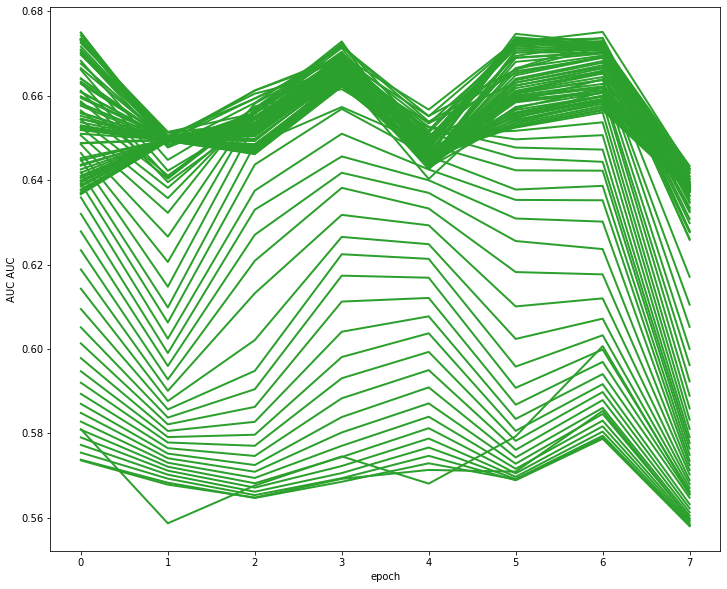

In [360]:
# f, axarr = plt.subplots(1, 1, figsize=(10, 10))
# axarr.plot(val_aucs)
plot_epoch("AUC",val_aucs, color=colors[2])

In [ ]:
plot_epoch("Val Losses", val_losses, color=colors[2])

### Privacy Loss

In [361]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=outputs, indices=s_labels, noise_eps=.2, delta=1e-5)
print(f"Data Dependent Analysis: {str(data_dep_eps)}")
print(f"Data Independent Analysis: {str(data_ind_eps)}")

Data Dependent Analysis: 4624.152925463095
Data Independent Analysis: 4624.152925464971


In [362]:
student_model

HCModel(
  (layers): Sequential(
    (0): Linear(in_features=104, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)

Text(0, 0.5, 'AUC')

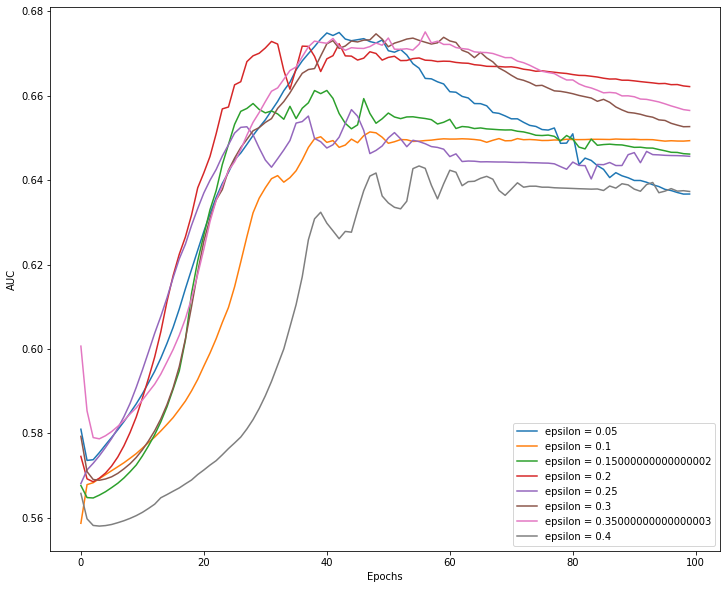

In [363]:
for idx, loss in enumerate(val_aucs):
    plt.plot(range(len(loss)),loss, label=f'epsilon = {epsilons[idx]}')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('AUC')


In [383]:
%%time
epsilons = np.arange(0.01,0.25,0.01)
depends = []
independs = []
diff = []
for epsilon in epsilons:
    print(f"----------------{epsilon}")
    data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=outputs, indices=s_labels, noise_eps=epsilon, delta=1e-5)
    depends.append(data_dep_eps)
    independs.append(data_ind_eps)
    diff.append(data_dep_eps-data_ind_eps)
    print(f"Data Dependent Analysis: {str(data_dep_eps)}")
    print(f"Data Independent Analysis: {str(data_ind_eps)}\n")

----------------0.01
Data Dependent Analysis: 23.044525464976864
Data Independent Analysis: 23.044525464970228

----------------0.02
Data Dependent Analysis: 57.63932546499678
Data Independent Analysis: 57.639325464970234

----------------0.03
Data Dependent Analysis: 115.29732546501812
Data Independent Analysis: 115.29732546497021

----------------0.04
Data Dependent Analysis: 196.01852546507644
Data Independent Analysis: 196.01852546497025

----------------0.05
Data Dependent Analysis: 299.80292546485305
Data Independent Analysis: 299.8029254649703

----------------0.060000000000000005
Data Dependent Analysis: 426.6505254651618
Data Independent Analysis: 426.6505254649703

----------------0.06999999999999999
Data Dependent Analysis: 576.5613254651822
Data Independent Analysis: 576.5613254649701

----------------0.08
Data Dependent Analysis: 749.535325465395
Data Independent Analysis: 749.5353254649702

----------------0.09
Data Dependent Analysis: 945.5725254655933
Data Independent A

In [395]:
absdiff = []
for i,_ in enumerate(depends):
    absdiff.append(abs(depends[i]-independs[i]))

Text(0, 0.5, 'Delta of Dependent Independent')

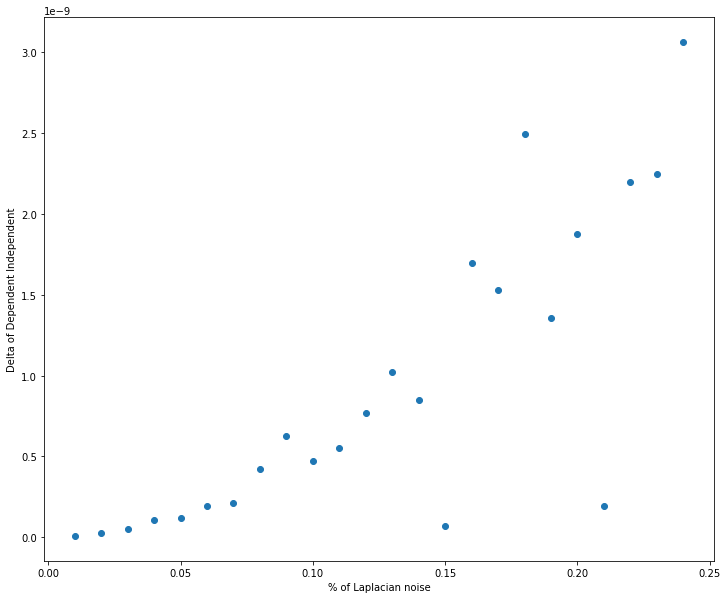

In [397]:
plt.scatter(epsilons,absdiff,label = "Delta of Dependent Independent")
# plt.scatter(epsilons,diff,label = "Delta of Dependent Independent")
plt.xlabel('% of Laplacian noise')
plt.ylabel('Delta of Dependent Independent')

Text(0, 0.5, 'Delta of Dependent Independent')

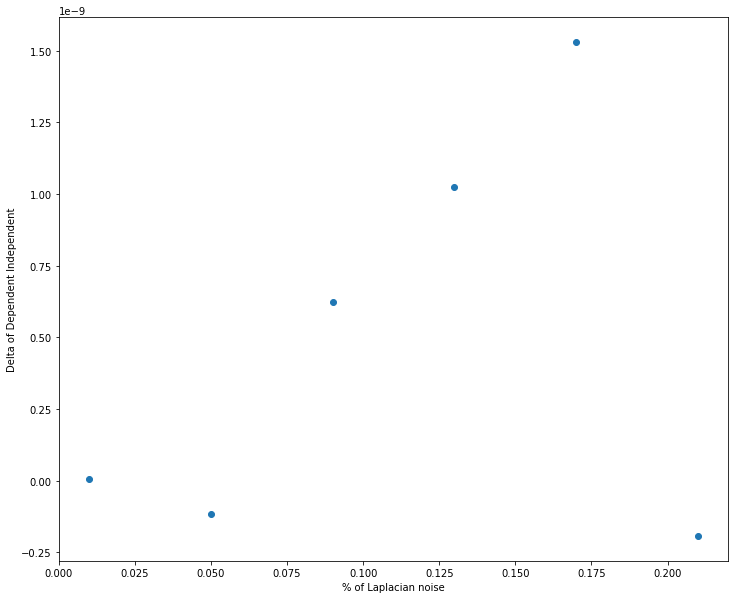

In [399]:
plt.scatter(epsilons,diff_many,label = "Delta of Dependent Independent")
# plt.scatter(epsilons,diff,label = "Delta of Dependent Independent")
plt.xlabel('% of Laplacian noise')
plt.ylabel('Delta of Dependent Independent')